In [1]:
import sys
import os
from dotenv import load_dotenv
load_dotenv()
sys.path.insert(0, os.getenv('SRC_PATH'))

import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3
from src.volsurface import GridInterpVolSurface, KernelVolSurface, VAEPWVolSurface, VAEVolSurface
from src.utils.data_helper import clean_data, VolSurfPointwiseDataset

import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from src.train import Trainer

import json

DB_PATH = os.getenv('DB_PATH')
CSV_PATH = os.getenv('CSV_PATH')
conn = sqlite3.connect(DB_PATH)
cursor = conn.cursor()

pd.set_option('future.no_silent_downcasting', True)

In [2]:
from src.utils.logger import setup_logger
logger = setup_logger('train')

In [3]:
query = """
SELECT date, symbol, exdate, last_date, cp_flag, strike_price, best_bid, best_offer, volume, open_interest, impl_volatility, delta
FROM opprc
"""
dtype = {
    'symbol': 'string',
    'cp_flag': 'string',
    'strike_price': 'float64',
    'best_bid': 'float64',
    'best_offer': 'float64',
    'volume': 'int64',
    'open_interest': 'int64',
    'impl_volatility': 'float64',
    'delta': 'float64'
}
df_raw = pd.read_sql_query(query, conn, parse_dates=['date', 'exdate', 'last_date'])
df_raw = df_raw.replace('', np.nan) # sqlite returns empty strings for NULL values
df_raw = df_raw.astype(dtype)

df = clean_data(df_raw)

[2025-04-21 15:26:50] [INFO] src.utils.data_helper (50) : Bad data - Filtered 1110238 rows, Retained sample 76.67%
[2025-04-21 15:27:01] [INFO] src.utils.data_helper (63) : Consecutive trading stats completed
[2025-04-21 15:27:02] [INFO] src.utils.data_helper (86) : Consecutive trading - Filtered 2341950 rows, Retained sample 35.81%
[2025-04-21 15:27:02] [INFO] src.utils.data_helper (91) : Moneyness calculation completed


# Baseline, 9*8 grid params already tuned

In [46]:
model_name = "vae_pw_improve_0"
train_model = True
load_model = False
save_model = False
data_dir = CSV_PATH + "/predicted_vol_surfaces.json"  # Path to the volatility surfaces dataset
batch_size = 32
epochs = 10

In [47]:
maturity_grid = np.array([1, 7, 30, 60, 90, 180, 360, 720])
delta_grid = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [48]:
SRC_PATH = os.getenv('SRC_PATH')
os.chdir(SRC_PATH)
trainer = Trainer(model_name)
trainer.create_model()

[2025-04-21 17:25:30] [INFO] src.train (62) : Using device: mps


In [49]:
with open(data_dir, "r") as f:
    data = json.load(f)

In [50]:
mapping_ids = {dt: i for i, dt in enumerate(sorted(map(lambda x: x[:10], data.keys())))}

In [51]:
df['mapping_ids'] = df['date'].dt.strftime('%Y-%m-%d').map(mapping_ids)

In [52]:
vol_surfaces = []
for key in sorted(data.keys()):
    surface = torch.tensor(data[key], dtype=torch.float32)
    vol_surfaces.append(surface.flatten())  # Flatten 2D to 1D

data_tensor = torch.stack(vol_surfaces)
pw_grid_data = torch.tensor(df[['moneyness', 'ttm']].values, dtype=torch.float32)
# !only for test run
# pw_grid_data[:, 0] = pw_grid_data[:, 0] / 365.0
pw_vol_data = torch.tensor(df['impl_volatility'].values, dtype=torch.float32)
mapping_ids = torch.tensor(df['mapping_ids'].values).long()

assert data_tensor.shape[0] == max(mapping_ids) + 1

In [53]:
dataset = VolSurfPointwiseDataset(pw_grid_data, pw_vol_data, data_tensor, mapping_ids)
train_loader = DataLoader(
    dataset, 
    batch_size=trainer.batch_size,
    shuffle=True
)

In [36]:
trainer.hypertune(train_loader)

Hypertune!! {'learning_rate': <ray.tune.search.sample.Categorical object at 0x39688f790>, 'batch_size': <ray.tune.search.sample.Categorical object at 0x39688d990>, 'latent_dim': <ray.tune.search.sample.Categorical object at 0x39688c220>, 'hidden_dim': <ray.tune.search.sample.Categorical object at 0x39688c310>, 'input_dim': <ray.tune.search.sample.Categorical object at 0x39688f880>}


2025-04-21 16:07:29,523	INFO worker.py:1812 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8266 
2025-04-21 16:07:30,041	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.
2025-04-21 16:07:30,043	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949
E0000 00:00:1745266050.186609 3360192 tcp_posix.cc:596] recvmsg encountered uncommon error: Message too long


(raylet) Warning: The actor ImplicitFunc is very large (50 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.
== Status ==
Current time: 2025-04-21 16:07:30 (running for 00:00:00.58)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 2.0/8 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2025-04-21_16-07-28_571532_64755/artifacts/2025-04-21_16-07-30/lambda_2025-04-21_16-07-30/driver_artifacts
Number of trials: 2/2 (2 PENDING)
+--------------------+----------+-------+--------------+--------------+-------------+--------------+-----------------+
| Trial name         | status   | loc   |   batch_size | hidden_dim   |   input_dim |   latent_dim |   learning_rate |
|--------------------+----------+-------+--------------+--------------+-------------+--------------+-----------------|
| lambd

(pid=65298) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=65298) E0000 00:00:1745266051.153128 3360625 tcp_posix.cc:596] recvmsg encountered uncommon error: Message too long


== Status ==
Current time: 2025-04-21 16:07:35 (running for 00:00:05.64)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 2.0/8 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2025-04-21_16-07-28_571532_64755/artifacts/2025-04-21_16-07-30/lambda_2025-04-21_16-07-30/driver_artifacts
Number of trials: 2/2 (2 RUNNING)
+--------------------+----------+-----------------+--------------+--------------+-------------+--------------+-----------------+
| Trial name         | status   | loc             |   batch_size | hidden_dim   |   input_dim |   latent_dim |   learning_rate |
|--------------------+----------+-----------------+--------------+--------------+-------------+--------------+-----------------|
| lambda_41135_00000 | RUNNING  | 127.0.0.1:65298 |          128 | [32, 32]     |          72 |            4 |          0.0001 |
| lambda_41135_00001 | RUNNING  | 127.0.0.1:65297 |           64 | [32, 

(<lambda> pid=65298) [2025-04-21 16:10:29] [INFO] src.train (181) : Loss: 0.0079
(pid=65297) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=65297) E0000 00:00:1745266051.205706 3360626 tcp_posix.cc:596] recvmsg encountered uncommon error: Message too long


== Status ==
Current time: 2025-04-21 16:10:32 (running for 00:03:02.49)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: -10195.38843889162
Logical resource usage: 2.0/8 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2025-04-21_16-07-28_571532_64755/artifacts/2025-04-21_16-07-30/lambda_2025-04-21_16-07-30/driver_artifacts
Number of trials: 2/2 (2 RUNNING)
+--------------------+----------+-----------------+--------------+--------------+-------------+--------------+-----------------+---------+----------------------+
| Trial name         | status   | loc             |   batch_size | hidden_dim   |   input_dim |   latent_dim |   learning_rate |    loss |   training_iteration |
|--------------------+----------+-----------------+--------------+--------------+-------------+--------------+-----------------+---------+----------------------|
| lambda_41135_00000 | RUNNING  | 127.0.0.1:65298 |          128 | [32, 32]     |       

(<lambda> pid=65298) [2025-04-21 16:13:21] [INFO] src.train (181) : Loss: 0.0054 [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)


== Status ==
Current time: 2025-04-21 16:13:24 (running for 00:05:54.30)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: -10195.38843889162
Logical resource usage: 2.0/8 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2025-04-21_16-07-28_571532_64755/artifacts/2025-04-21_16-07-30/lambda_2025-04-21_16-07-30/driver_artifacts
Number of trials: 2/2 (2 RUNNING)
+--------------------+----------+-----------------+--------------+--------------+-------------+--------------+-----------------+---------+----------------------+
| Trial name         | status   | loc             |   batch_size | hidden_dim   |   input_dim |   latent_dim |   learning_rate |    loss |   training_iteration |
|--------------------+----------+-----------------+--------------+--------------+-------------+--------------+-----------------+---------+----------------------|
| lambda_41135_00000 | RUNNING  | 127.0.0.1:65298 |          128 | [32, 32]     |       

(<lambda> pid=65298) [2025-04-21 16:16:13] [INFO] src.train (181) : Loss: 0.0047 [repeated 2x across cluster]


== Status ==
Current time: 2025-04-21 16:16:16 (running for 00:08:46.04)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: -10195.38843889162
Logical resource usage: 2.0/8 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2025-04-21_16-07-28_571532_64755/artifacts/2025-04-21_16-07-30/lambda_2025-04-21_16-07-30/driver_artifacts
Number of trials: 2/2 (2 RUNNING)
+--------------------+----------+-----------------+--------------+--------------+-------------+--------------+-----------------+---------+----------------------+
| Trial name         | status   | loc             |   batch_size | hidden_dim   |   input_dim |   latent_dim |   learning_rate |    loss |   training_iteration |
|--------------------+----------+-----------------+--------------+--------------+-------------+--------------+-----------------+---------+----------------------|
| lambda_41135_00000 | RUNNING  | 127.0.0.1:65298 |          128 | [32, 32]     |       

(<lambda> pid=65298) [2025-04-21 16:19:04] [INFO] src.train (181) : Loss: 0.0044 [repeated 2x across cluster]
(pid=gcs_server) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=gcs_server) I0000 00:00:1745266745.817232 3359982 chttp2_transport.cc:1182] ipv4:127.0.0.1:54446: Got goaway [2] err=UNAVAILABLE:GOAWAY received; Error code: 2; Debug Text: Cancelling all calls {file:"external/com_github_grpc_grpc/src/core/ext/transport/chttp2/transport/chttp2_transport.cc", file_line:1171, created_time:"2025-04-21T16:19:05.817228-04:00", http2_error:2, grpc_status:14}


== Status ==
Current time: 2025-04-21 16:19:07 (running for 00:11:37.78)
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: -5759.906163925305 | Iter 1.000: -10195.38843889162
Logical resource usage: 1.0/8 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2025-04-21_16-07-28_571532_64755/artifacts/2025-04-21_16-07-30/lambda_2025-04-21_16-07-30/driver_artifacts
Number of trials: 2/2 (1 RUNNING, 1 TERMINATED)
+--------------------+------------+-----------------+--------------+--------------+-------------+--------------+-----------------+---------+----------------------+
| Trial name         | status     | loc             |   batch_size | hidden_dim   |   input_dim |   latent_dim |   learning_rate |    loss |   training_iteration |
|--------------------+------------+-----------------+--------------+--------------+-------------+--------------+-----------------+---------+----------------------|
| lambda_41135_00000 | RUNNING    | 127.0.0.1:65298 | 

(<lambda> pid=65298) [2025-04-21 16:21:42] [INFO] src.train (181) : Loss: 0.0042 [repeated 2x across cluster]


== Status ==
Current time: 2025-04-21 16:21:44 (running for 00:14:14.56)
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: -5759.906163925305 | Iter 1.000: -10195.38843889162
Logical resource usage: 1.0/8 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2025-04-21_16-07-28_571532_64755/artifacts/2025-04-21_16-07-30/lambda_2025-04-21_16-07-30/driver_artifacts
Number of trials: 2/2 (1 RUNNING, 1 TERMINATED)
+--------------------+------------+-----------------+--------------+--------------+-------------+--------------+-----------------+---------+----------------------+
| Trial name         | status     | loc             |   batch_size | hidden_dim   |   input_dim |   latent_dim |   learning_rate |    loss |   training_iteration |
|--------------------+------------+-----------------+--------------+--------------+-------------+--------------+-----------------+---------+----------------------|
| lambda_41135_00000 | RUNNING    | 127.0.0.1:65298 | 

(<lambda> pid=65298) [2025-04-21 16:24:22] [INFO] src.train (181) : Loss: 0.0041


== Status ==
Current time: 2025-04-21 16:24:26 (running for 00:16:56.62)
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: -5759.906163925305 | Iter 1.000: -10195.38843889162
Logical resource usage: 1.0/8 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2025-04-21_16-07-28_571532_64755/artifacts/2025-04-21_16-07-30/lambda_2025-04-21_16-07-30/driver_artifacts
Number of trials: 2/2 (1 RUNNING, 1 TERMINATED)
+--------------------+------------+-----------------+--------------+--------------+-------------+--------------+-----------------+---------+----------------------+
| Trial name         | status     | loc             |   batch_size | hidden_dim   |   input_dim |   latent_dim |   learning_rate |    loss |   training_iteration |
|--------------------+------------+-----------------+--------------+--------------+-------------+--------------+-----------------+---------+----------------------|
| lambda_41135_00000 | RUNNING    | 127.0.0.1:65298 | 

(<lambda> pid=65298) [2025-04-21 16:27:06] [INFO] src.train (181) : Loss: 0.0040


== Status ==
Current time: 2025-04-21 16:27:08 (running for 00:19:38.26)
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: -5759.906163925305 | Iter 1.000: -10195.38843889162
Logical resource usage: 1.0/8 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2025-04-21_16-07-28_571532_64755/artifacts/2025-04-21_16-07-30/lambda_2025-04-21_16-07-30/driver_artifacts
Number of trials: 2/2 (1 RUNNING, 1 TERMINATED)
+--------------------+------------+-----------------+--------------+--------------+-------------+--------------+-----------------+---------+----------------------+
| Trial name         | status     | loc             |   batch_size | hidden_dim   |   input_dim |   latent_dim |   learning_rate |    loss |   training_iteration |
|--------------------+------------+-----------------+--------------+--------------+-------------+--------------+-----------------+---------+----------------------|
| lambda_41135_00000 | RUNNING    | 127.0.0.1:65298 | 

(<lambda> pid=65298) [2025-04-21 16:29:46] [INFO] src.train (181) : Loss: 0.0040


== Status ==
Current time: 2025-04-21 16:29:50 (running for 00:22:19.95)
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: -5759.906163925305 | Iter 1.000: -10195.38843889162
Logical resource usage: 1.0/8 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2025-04-21_16-07-28_571532_64755/artifacts/2025-04-21_16-07-30/lambda_2025-04-21_16-07-30/driver_artifacts
Number of trials: 2/2 (1 RUNNING, 1 TERMINATED)
+--------------------+------------+-----------------+--------------+--------------+-------------+--------------+-----------------+---------+----------------------+
| Trial name         | status     | loc             |   batch_size | hidden_dim   |   input_dim |   latent_dim |   learning_rate |    loss |   training_iteration |
|--------------------+------------+-----------------+--------------+--------------+-------------+--------------+-----------------+---------+----------------------|
| lambda_41135_00000 | RUNNING    | 127.0.0.1:65298 | 

(<lambda> pid=65298) [2025-04-21 16:32:25] [INFO] src.train (181) : Loss: 0.0039


== Status ==
Current time: 2025-04-21 16:32:26 (running for 00:24:56.54)
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: -5759.906163925305 | Iter 1.000: -10195.38843889162
Logical resource usage: 1.0/8 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2025-04-21_16-07-28_571532_64755/artifacts/2025-04-21_16-07-30/lambda_2025-04-21_16-07-30/driver_artifacts
Number of trials: 2/2 (1 RUNNING, 1 TERMINATED)
+--------------------+------------+-----------------+--------------+--------------+-------------+--------------+-----------------+---------+----------------------+
| Trial name         | status     | loc             |   batch_size | hidden_dim   |   input_dim |   latent_dim |   learning_rate |    loss |   training_iteration |
|--------------------+------------+-----------------+--------------+--------------+-------------+--------------+-----------------+---------+----------------------|
| lambda_41135_00000 | RUNNING    | 127.0.0.1:65298 | 

2025-04-21 16:35:06,809	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/Users/zlx/ray_results/lambda_2025-04-21_16-07-30' in 0.0022s.
2025-04-21 16:35:06,812	INFO tune.py:1041 -- Total run time: 1656.77 seconds (1656.65 seconds for the tuning loop).


== Status ==
Current time: 2025-04-21 16:35:06 (running for 00:27:36.66)
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: -5759.906163925305 | Iter 1.000: -10195.38843889162
Logical resource usage: 1.0/8 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2025-04-21_16-07-28_571532_64755/artifacts/2025-04-21_16-07-30/lambda_2025-04-21_16-07-30/driver_artifacts
Number of trials: 2/2 (2 TERMINATED)
+--------------------+------------+-----------------+--------------+--------------+-------------+--------------+-----------------+---------+----------------------+
| Trial name         | status     | loc             |   batch_size | hidden_dim   |   input_dim |   latent_dim |   learning_rate |    loss |   training_iteration |
|--------------------+------------+-----------------+--------------+--------------+-------------+--------------+-----------------+---------+----------------------|
| lambda_41135_00000 | TERMINATED | 127.0.0.1:65298 |          12

(<lambda> pid=65298) [2025-04-21 16:35:06] [INFO] src.train (181) : Loss: 0.0039


In [54]:
# Train the model
for epoch in range(epochs):
    logger.info(f"Epoch {epoch + 1}/{epochs}")
    trainer.train(train_loader)

[2025-04-21 17:25:36] [INFO] train (3) : Epoch 1/10
[2025-04-21 17:26:53] [INFO] src.train (181) : Loss: 0.0082
[2025-04-21 17:26:53] [INFO] train (3) : Epoch 2/10
[2025-04-21 17:28:11] [INFO] src.train (181) : Loss: 0.0071
[2025-04-21 17:28:11] [INFO] train (3) : Epoch 3/10
[2025-04-21 17:29:29] [INFO] src.train (181) : Loss: 0.0057
[2025-04-21 17:29:29] [INFO] train (3) : Epoch 4/10
[2025-04-21 17:30:48] [INFO] src.train (181) : Loss: 0.0050
[2025-04-21 17:30:48] [INFO] train (3) : Epoch 5/10
[2025-04-21 17:32:06] [INFO] src.train (181) : Loss: 0.0047
[2025-04-21 17:32:06] [INFO] train (3) : Epoch 6/10
[2025-04-21 17:33:25] [INFO] src.train (181) : Loss: 0.0045
[2025-04-21 17:33:25] [INFO] train (3) : Epoch 7/10
[2025-04-21 17:34:44] [INFO] src.train (181) : Loss: 0.0044
[2025-04-21 17:34:44] [INFO] train (3) : Epoch 8/10
[2025-04-21 17:36:03] [INFO] src.train (181) : Loss: 0.0043
[2025-04-21 17:36:03] [INFO] train (3) : Epoch 9/10
[2025-04-21 17:37:22] [INFO] src.train (181) : Loss:

In [55]:
torch.save(trainer.model.state_dict(), f"params/{trainer.model_name}.pth")

In [56]:
trainer.load_model( f"params/{trainer.model_name}.pth")

[2025-04-21 22:49:20] [INFO] src.train (138) : Model loaded from params/vae_pw_improve_0.pth


In [57]:
vae_gen = VAEPWVolSurface(
    vae_model=trainer.model
)
vae_gen.predict_grid(delta = delta_grid, maturity=maturity_grid)

array([[0.23975497, 0.18072826, 0.16639051, 0.16330257, 0.16192412,
        0.15993658, 0.15858367, 0.15811363],
       [0.23404717, 0.18161398, 0.16922238, 0.16658705, 0.16520861,
        0.16342917, 0.16255412, 0.16210017],
       [0.22336712, 0.18290177, 0.1740301 , 0.17147925, 0.1705578 ,
        0.16928157, 0.16841388, 0.16796014],
       [0.21492746, 0.18579447, 0.18134263, 0.17952517, 0.17860365,
        0.17732725, 0.17688432, 0.17887676],
       [0.21312273, 0.18280989, 0.19052958, 0.19587341, 0.19874606,
        0.20227069, 0.20518735, 0.20751086],
       [0.2278494 , 0.18435338, 0.1947231 , 0.20399603, 0.20429018,
        0.20888993, 0.21274835, 0.21547863],
       [0.24518129, 0.18991351, 0.2057285 , 0.21062165, 0.21171871,
        0.21912268, 0.22799152, 0.23392826],
       [0.2539911 , 0.19872487, 0.21259642, 0.21977845, 0.22370756,
        0.23226449, 0.24388802, 0.25491807],
       [0.28641358, 0.22269872, 0.2574705 , 0.28801015, 0.30076522,
        0.32054675, 0.336484

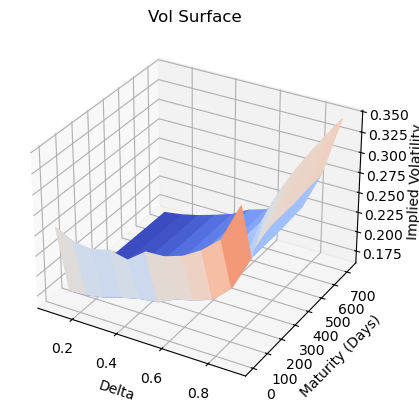

In [58]:
vae_gen.refresh()
ax = vae_gen.plot(delta_range = (0.1, 0.9), maturity_range = (1, 720))

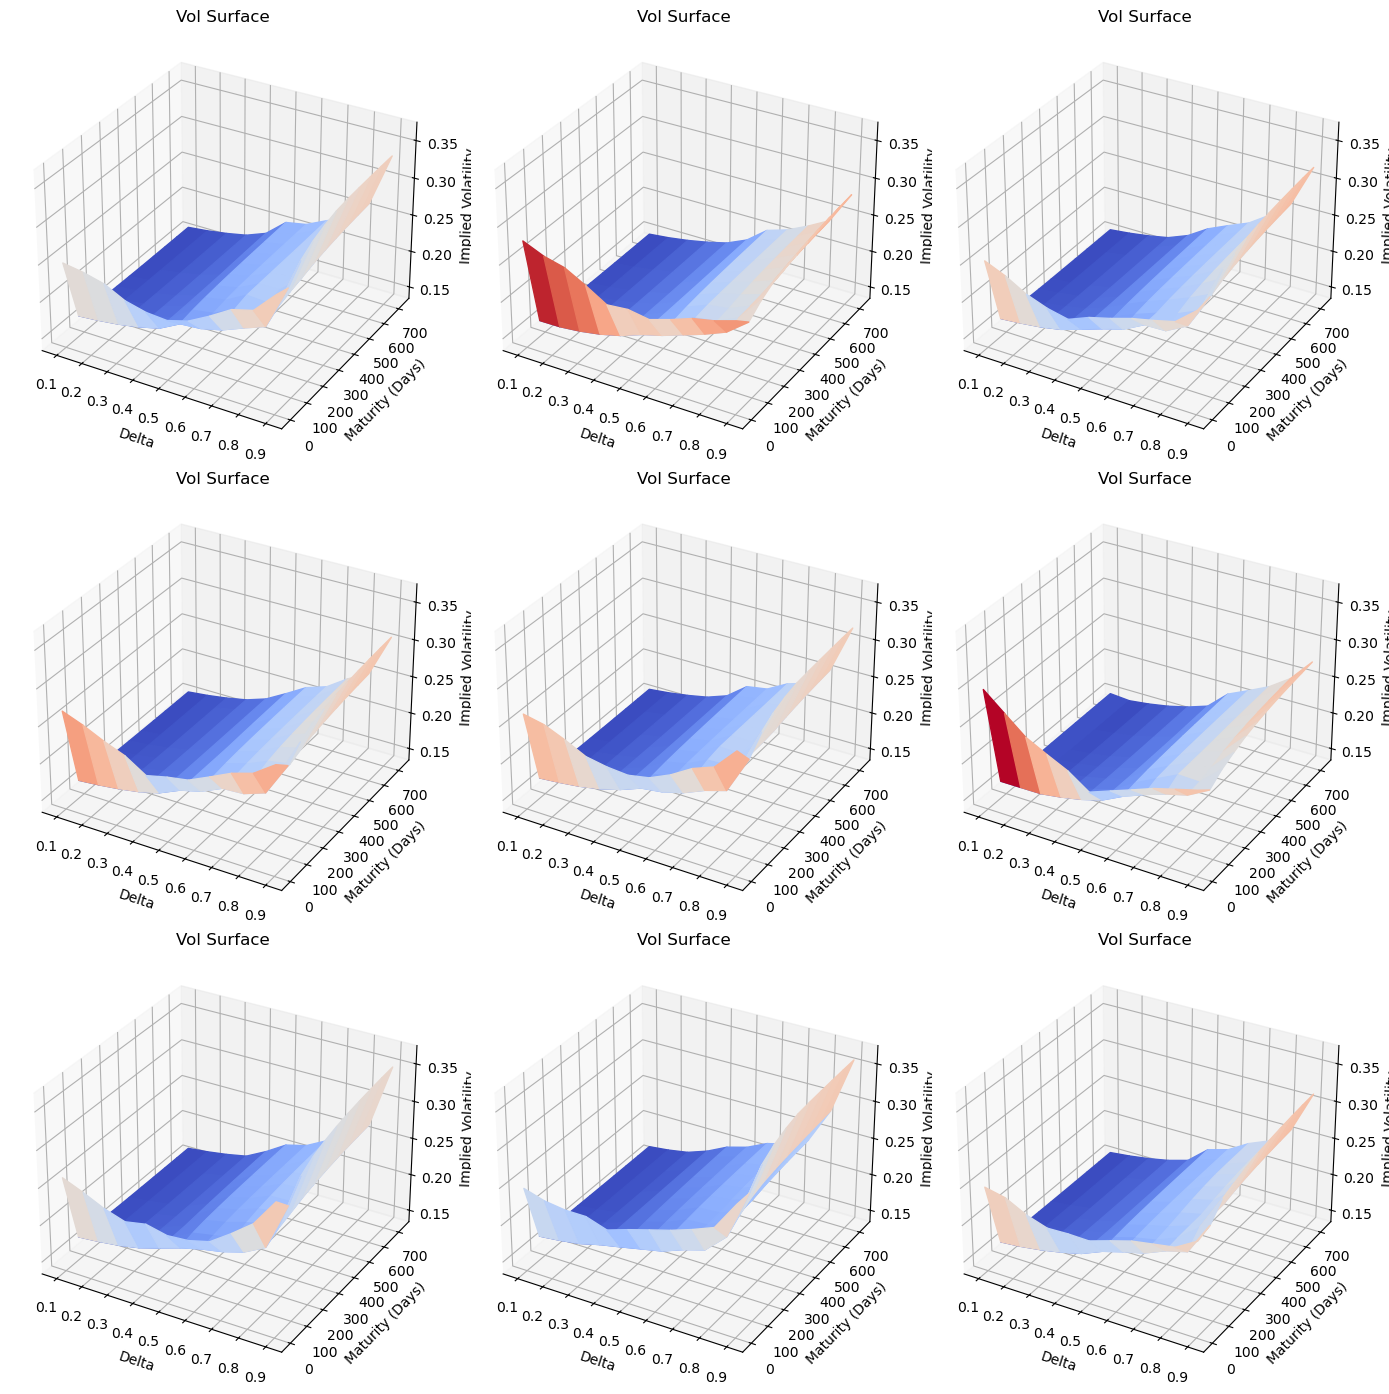

In [59]:
import matplotlib.pyplot as plt

fig_ = plt.figure(figsize=(14, 14))
axes = [[fig_.add_subplot(3, 3, i*3+j+1, projection='3d') for j in range(3)] for i in range(3)]

# First pass: generate all plots and collect z-limits
z_mins, z_maxs = [], []
for i in range(3):
    for j in range(3):
        vae_gen.refresh()
        vae_gen.plot(ax=axes[i][j], delta_range=(0.1, 0.9), maturity_range=(1, 720))
        
        # Store current z-axis limits
        z_mins.append(axes[i][j].get_zlim()[0])
        z_maxs.append(axes[i][j].get_zlim()[1])

# Calculate global limits with 5% padding
global_zmin = min(z_mins)
global_zmax = max(z_maxs)
padding = 0.05 * (global_zmax - global_zmin)

# Second pass: apply consistent z-axis limits
for i in range(3):
    for j in range(3):
        axes[i][j].set_zlim(
            global_zmin - padding, 
            global_zmax + padding
        )

plt.tight_layout()
plt.show()

In [20]:
vol_surfaces_tensor = torch.stack(vol_surfaces)

# Compute descriptive statistics
mean = vol_surfaces_tensor.mean().item()
std = vol_surfaces_tensor.std().item()
min_val = vol_surfaces_tensor.min().item()
max_val = vol_surfaces_tensor.max().item()

print(f"Mean: {mean}")
print(f"Standard Deviation: {std}")
print(f"Minimum Value: {min_val}")
print(f"Maximum Value: {max_val}")

Mean: 0.18290027976036072
Standard Deviation: 0.07631000876426697
Minimum Value: 2.79548589787737e-06
Maximum Value: 0.4679392874240875


In [24]:
mean = pw_vol_data.mean().item()
std = pw_vol_data.std().item()
min_val = pw_vol_data.min().item()
max_val = pw_vol_data.max().item()
print(f"Mean: {mean}")
print(f"Standard Deviation: {std}")
print(f"Minimum Value: {min_val}")
print(f"Maximum Value: {max_val}")


Mean: 0.2202116698026657
Standard Deviation: 0.08490786701440811
Minimum Value: 0.0326480008661747
Maximum Value: 5.791611194610596


In [46]:
df['moneyness'].describe()

count    1.306655e+06
mean     6.230497e-01
std      2.978849e-01
min      2.279000e-03
25%      3.937380e-01
50%      6.850460e-01
75%      8.939310e-01
max      9.994370e-01
Name: moneyness, dtype: float64

In [63]:
model_name = "vae_0"
train_model = True
load_model = False
save_model = True
data_dir = CSV_PATH + "/predicted_vol_surfaces.json"  # Path to the volatility surfaces dataset
batch_size = 32
epochs = 50
SRC_PATH = os.getenv('SRC_PATH')
os.chdir(SRC_PATH)
trainer_vanilla = Trainer(model_name)
trainer_vanilla.create_model()

with open(data_dir, "r") as f:
    data = json.load(f)

vol_surfaces = []
for key in data:
    surface = torch.tensor(data[key], dtype=torch.float32)
    vol_surfaces.append(surface.flatten())  # Flatten 2D to 1D

data_tensor = torch.stack(vol_surfaces)
dummy_labels = torch.zeros(len(data_tensor))

dataset = TensorDataset(data_tensor, dummy_labels)
train_loader = DataLoader(
    dataset, 
    batch_size=trainer_vanilla.batch_size,
    shuffle=True
)

# Train the model
for epoch in range(epochs):
    logger.info(f"Epoch {epoch + 1}/{epochs}")
    trainer_vanilla.train(train_loader)

if save_model:
    torch.save(
        trainer_vanilla.model.state_dict(), f"params/{trainer_vanilla.model_name}.pth"
    )


[2025-04-20 22:19:46] [INFO] src.train (61) : Using device: mps
[2025-04-20 22:19:46] [INFO] train (33) : Epoch 1/50
[2025-04-20 22:19:46] [INFO] train (33) : Epoch 1/50
[2025-04-20 22:19:46] [INFO] src.train (180) : Loss: 2.5210
[2025-04-20 22:19:46] [INFO] train (33) : Epoch 2/50
[2025-04-20 22:19:46] [INFO] train (33) : Epoch 2/50
[2025-04-20 22:19:46] [INFO] src.train (180) : Loss: 0.7748
[2025-04-20 22:19:46] [INFO] train (33) : Epoch 3/50
[2025-04-20 22:19:46] [INFO] train (33) : Epoch 3/50
[2025-04-20 22:19:46] [INFO] src.train (180) : Loss: 0.4639
[2025-04-20 22:19:46] [INFO] train (33) : Epoch 4/50
[2025-04-20 22:19:46] [INFO] train (33) : Epoch 4/50
[2025-04-20 22:19:46] [INFO] src.train (180) : Loss: 0.4084
[2025-04-20 22:19:46] [INFO] train (33) : Epoch 5/50
[2025-04-20 22:19:46] [INFO] train (33) : Epoch 5/50
[2025-04-20 22:19:46] [INFO] src.train (180) : Loss: 0.3420
[2025-04-20 22:19:46] [INFO] train (33) : Epoch 6/50
[2025-04-20 22:19:46] [INFO] train (33) : Epoch 6/50


In [64]:
trainer_vanilla.load_model( f"params/{trainer_vanilla.model_name}.pth")

[2025-04-20 22:19:48] [INFO] src.train (137) : Model loaded from params/vae_0.pth


In [65]:
vae_gen = VAEVolSurface(
    vae_model=trainer_vanilla.model
)

vae_gen.predict_grid(delta = delta_grid, maturity=maturity_grid)

array([[0.17921028, 0.17167488, 0.1568726 , 0.1511565 , 0.1475222 ,
        0.14810035, 0.14831498, 0.06442836],
       [0.1775843 , 0.17534778, 0.15975544, 0.1592144 , 0.15610896,
        0.1567328 , 0.1531816 , 0.07728352],
       [0.1805178 , 0.1683237 , 0.16726634, 0.16222487, 0.16554157,
        0.16719428, 0.16552293, 0.08659779],
       [0.18543704, 0.18214335, 0.16855672, 0.17585932, 0.16938734,
        0.17756505, 0.17457034, 0.09594125],
       [0.18401924, 0.1842877 , 0.17969921, 0.17901269, 0.1862523 ,
        0.1923917 , 0.19256186, 0.09896576],
       [0.18699718, 0.18901393, 0.18725944, 0.19267344, 0.19535933,
        0.20188197, 0.20798655, 0.10606338],
       [0.19361188, 0.19621979, 0.20041035, 0.20718391, 0.21557036,
        0.22089182, 0.23344475, 0.12342565],
       [0.19782954, 0.20195706, 0.21287781, 0.22839732, 0.23293933,
        0.24803475, 0.2563014 , 0.13629292],
       [0.21797428, 0.2261549 , 0.25011012, 0.27109352, 0.28203955,
        0.30222812, 0.311463

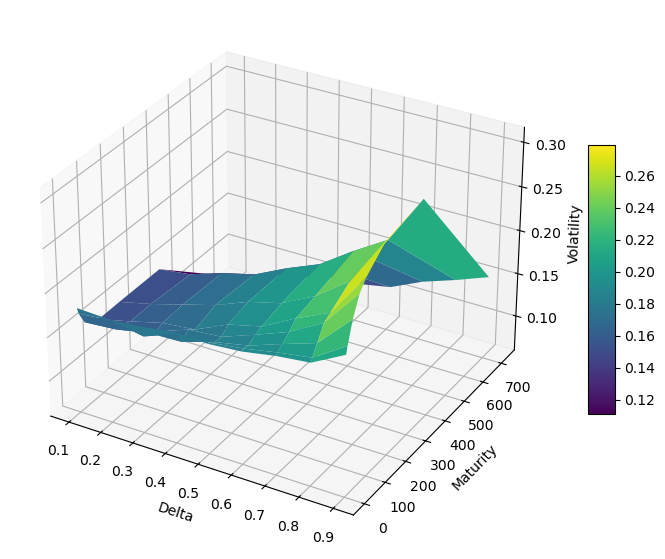

In [66]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
vol_to_plot = vae_gen.predict_grid(delta=delta_grid, maturity=maturity_grid)
maturity, delta = np.meshgrid(maturity_grid, delta_grid)

# Plot the surface
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(delta, maturity, vol_to_plot, cmap='viridis')  # Swap maturity and delta

# Add labels and color bar
ax.set_xlabel('Delta')  # Update label
ax.set_ylabel('Maturity')  # Update label
ax.set_zlabel('Volatility')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

plt.show()

# filter out extremely large volatilities (outliers) in pw_vol and the corresponding pw_grid

In [33]:
df_clipped = df[df['impl_volatility'] < 0.5]
print(f"retained percentage: {len(df_clipped) / len(df) * 100:.2f}%")

retained percentage: 99.07%


In [34]:
model_name = "vae_pw_improve_1"
train_model = True
load_model = False
save_model = False
data_dir = CSV_PATH + "/predicted_vol_surfaces.json"  # Path to the volatility surfaces dataset
batch_size = 32
epochs = 10

In [35]:
maturity_grid = np.array([1, 7, 30, 60, 90, 180, 360, 720])
delta_grid = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [36]:
SRC_PATH = os.getenv('SRC_PATH')
os.chdir(SRC_PATH)
trainer_1 = Trainer(model_name)
trainer_1.create_model()

[2025-04-20 16:04:39] [INFO] src.train (61) : Using device: mps


In [37]:
pw_grid_data = torch.tensor(df_clipped[['ttm', 'moneyness']].values, dtype=torch.float32)
# !only for test run
pw_grid_data[:, 0] = pw_grid_data[:, 0] / 365.0
pw_vol_data = torch.tensor(df_clipped['impl_volatility'].values, dtype=torch.float32)
mapping_ids = torch.tensor(df_clipped['mapping_ids'].values).long()

assert data_tensor.shape[0] == max(mapping_ids) + 1

In [38]:
dataset = VolSurfPointwiseDataset(pw_grid_data, pw_vol_data, data_tensor, mapping_ids)
train_loader = DataLoader(
    dataset, 
    batch_size=trainer_1.batch_size,
    shuffle=True
)

In [40]:
trainer_1.hypertune(train_loader)


2025-04-20 16:07:16,547	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Hypertune!! {'learning_rate': <ray.tune.search.sample.Categorical object at 0x3b5ba9b70>, 'batch_size': <ray.tune.search.sample.Categorical object at 0x3b5ba9960>, 'latent_dim': <ray.tune.search.sample.Categorical object at 0x3b5ba9cf0>, 'hidden_dim': <ray.tune.search.sample.Categorical object at 0x3b5ba9c90>, 'input_dim': <ray.tune.search.sample.Categorical object at 0x3b5ba9c00>}


E0000 00:00:1745179636.666257 2848300 tcp_posix.cc:596] recvmsg encountered uncommon error: Message too long


== Status ==
Current time: 2025-04-20 16:07:17 (running for 00:00:00.58)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 2.0/8 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2025-04-20_16-06-47_440678_53479/artifacts/2025-04-20_16-07-16/lambda_2025-04-20_16-07-16/driver_artifacts
Number of trials: 2/2 (2 PENDING)


== Status ==
Current time: 2025-04-20 16:07:22 (running for 00:00:05.65)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 2.0/8 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2025-04-20_16-06-47_440678_53479/artifacts/2025-04-20_16-07-16/lambda_2025-04-20_16-07-16/driver_artifacts
Number of trials: 2/2 (2 RUNNING)


== Status ==
Current time: 2025-04-20 16:07:27 (running for 00:00:10.71)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: No

2025-04-20 16:33:05,018	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/Users/zlx/ray_results/lambda_2025-04-20_16-07-16' in 0.0029s.
2025-04-20 16:33:05,021	INFO tune.py:1041 -- Total run time: 1548.47 seconds (1548.36 seconds for the tuning loop).


== Status ==
Current time: 2025-04-20 16:33:05 (running for 00:25:48.37)
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: -5751.433558963705 | Iter 1.000: -5731.989296980668
Logical resource usage: 1.0/8 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2025-04-20_16-06-47_440678_53479/artifacts/2025-04-20_16-07-16/lambda_2025-04-20_16-07-16/driver_artifacts
Number of trials: 2/2 (2 TERMINATED)


Best config: {'learning_rate': 0.0001, 'batch_size': 64, 'latent_dim': 4, 'hidden_dim': [32, 32], 'input_dim': 72}


In [41]:
# Train the model after tune
for epoch in range(epochs):
    logger.info(f"Epoch {epoch + 1}/{epochs}")
    trainer_1.train(train_loader)

[2025-04-20 16:41:02] [INFO] train (3) : Epoch 1/10
[2025-04-20 16:43:08] [INFO] src.train (180) : Loss: 0.0047
[2025-04-20 16:43:08] [INFO] train (3) : Epoch 2/10
[2025-04-20 16:45:16] [INFO] src.train (180) : Loss: 0.0034
[2025-04-20 16:45:16] [INFO] train (3) : Epoch 3/10
[2025-04-20 16:47:27] [INFO] src.train (180) : Loss: 0.0033
[2025-04-20 16:47:27] [INFO] train (3) : Epoch 4/10
[2025-04-20 16:49:37] [INFO] src.train (180) : Loss: 0.0032
[2025-04-20 16:49:37] [INFO] train (3) : Epoch 5/10
[2025-04-20 16:51:52] [INFO] src.train (180) : Loss: 0.0031
[2025-04-20 16:51:52] [INFO] train (3) : Epoch 6/10
[2025-04-20 16:54:08] [INFO] src.train (180) : Loss: 0.0031
[2025-04-20 16:54:08] [INFO] train (3) : Epoch 7/10
[2025-04-20 16:56:20] [INFO] src.train (180) : Loss: 0.0030
[2025-04-20 16:56:20] [INFO] train (3) : Epoch 8/10
[2025-04-20 16:58:34] [INFO] src.train (180) : Loss: 0.0030
[2025-04-20 16:58:34] [INFO] train (3) : Epoch 9/10
[2025-04-20 17:00:50] [INFO] src.train (180) : Loss:

In [42]:
torch.save(trainer_1.model.state_dict(), f"params/{trainer_1.model_name}.pth")

In [43]:
trainer_1.load_model( f"params/{trainer_1.model_name}.pth")

[2025-04-20 17:07:41] [INFO] src.train (137) : Model loaded from params/vae_pw_improve_1.pth


In [46]:
trainer_1.model

VAE_PW_II(
  (encoder): VaeEncoder(
    (mlp): MLP(
      (hidden_layers): ModuleList(
        (0): Linear(in_features=72, out_features=32, bias=True)
      )
      (output_layer): Linear(in_features=32, out_features=8, bias=True)
      (activation): ReLU()
    )
  )
  (decoder): VaeDecoder(
    (mlp): MLP(
      (hidden_layers): ModuleList(
        (0): Linear(in_features=4, out_features=32, bias=True)
      )
      (output_layer): Linear(in_features=32, out_features=1, bias=True)
      (activation): ReLU()
    )
  )
  (dltemb_net): EmbeddingMLP(
    (embed_net): MLP(
      (hidden_layers): ModuleList(
        (0): Linear(in_features=10, out_features=4, bias=True)
      )
      (output_layer): Linear(in_features=4, out_features=4, bias=True)
      (activation): SiLU()
    )
  )
  (ttmemb_net): EmbeddingMLP(
    (embed_net): MLP(
      (hidden_layers): ModuleList(
        (0): Linear(in_features=10, out_features=4, bias=True)
      )
      (output_layer): Linear(in_features=4, out_feat

In [44]:
vae_gen_1 = VAEPWVolSurface(
    vae_model=trainer_1.model
)
vae_gen_1.predict_grid(delta = delta_grid, maturity=maturity_grid)

array([[0.3190164 , 1.5820023 , 2.2652268 , 2.3652933 , 2.3688467 ,
        2.279745  , 2.0626657 , 1.7391351 ],
       [0.3507371 , 1.5786883 , 2.2619128 , 2.374338  , 2.3758647 ,
        2.2764308 , 2.0593512 , 1.7358207 ],
       [0.36839586, 1.5624157 , 2.24564   , 2.358066  , 2.3595927 ,
        2.2601583 , 2.043079  , 1.7195479 ],
       [0.3786183 , 1.5504856 , 2.2337096 , 2.3461356 , 2.3476617 ,
        2.2482283 , 2.0311494 , 1.7076181 ],
       [0.38127813, 1.5401942 , 2.2234185 , 2.3358448 , 2.33737   ,
        2.2379367 , 2.0208573 , 1.6973268 ],
       [0.38039458, 1.53062   , 2.2138445 , 2.3262699 , 2.327797  ,
        2.228363  , 2.0112834 , 1.6877533 ],
       [0.3792013 , 1.5218078 , 2.205032  , 2.3174577 , 2.318984  ,
        2.2195494 , 2.0024712 , 1.6789397 ],
       [0.37886417, 1.5138584 , 2.197083  , 2.3095086 , 2.311035  ,
        2.2116008 , 1.994522  , 1.6709915 ],
       [0.37948278, 1.5068232 , 2.190047  , 2.3024735 , 2.3039997 ,
        2.2045653 , 1.987485

<Axes3D: title={'center': 'Vol Surface'}, xlabel='Delta', ylabel='Maturity (Days)', zlabel='Implied Volatility'>

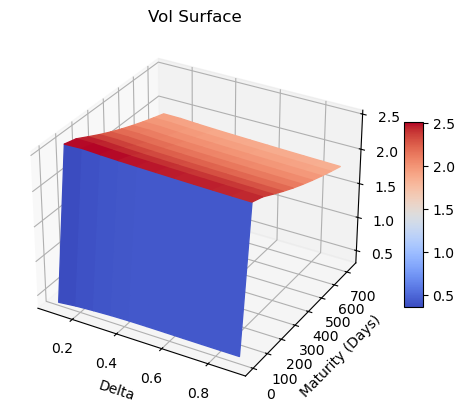

In [45]:
vae_gen_1.refresh()
vae_gen_1.plot(delta_range = (0.1, 0.9), maturity_range = (1, 720))